# Project 2 Code
## Steps
1. Preprocess titles by removing stopwords and stemming
  - stopwords are common english tokens like "the" and "a"
  - stemming is reducing words to their roots
2. Vectorize the titles by using TF-IDF on each pairing
  - define some `vectorSize` and either pad the vectors or limit them to it
3. Train a Siamese neural network to back a similarity scoring
4. Use some threshold to determine if the pairs are `agree`, `disagree`, or `unrelated`


In [1]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

# preprocess a single title
def preprocess_title(title):
    # convert to lowercase and remove punctuation
    title = title.lower()
    translator = str.maketrans('', '', string.punctuation)
    title = title.translate(translator)
    # tokenize
    words = nltk.word_tokenize(title)
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # stem the remaining words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # join the stemmed words back into a single string
    stemmed_title = ' '.join(words)
    return stemmed_title

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yousef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yousef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# ensure a vector is at most max_len by either trimming it or adding empty
def ensure_length(lst, max_len, empty):
    if len(lst) > max_len:
        lst = lst[:max_len]
    elif len(lst) < max_len:
        lst += [empty] * (max_len - len(lst))
    return lst

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

titles = [preprocess_title(title) for title in ['I am a title of a faked news article...', 'I\'m not really sure if this news title is real?']]
# create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=100)

# compute the TF-IDF weights for the titles
max_len = 16
title_vectors = list(map(lambda v: ensure_length(v, max_len, 0), vectorizer.fit_transform(titles).todense().tolist()))
token_labels = ensure_length(vectorizer.get_feature_names_out().tolist(), max_len, "...")
# ensure legnth 10

pd.DataFrame(title_vectors, columns=token_labels)

,articl,fake,im,news,real,realli,sure,titl,...,...,...,...,...,...,...,...
0,0.576152,0.576152,0.000000,0.409937,0.000000,0.000000,0.000000,0.409937,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.446656,0.317800,0.446656,0.446656,0.446656,0.317800,0,0,0,0,0,0,0,0


In [3]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really lame. I hate it!") # returns an array, [neg score, neutral score, pos score,]

# cosine first
# euclidean

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JHP10\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.486, 'neu': 0.264, 'pos': 0.251, 'compound': -0.5519}

# Preprocessing

In [5]:
import os
train_df = pd.read_csv('train.csv')
train_df.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [29]:
# calculate sentiment scores for each article title
# expect about a 2 minute runtime
title1_sentiment_data = []
title2_sentiment_data = []

for title1, title2 in zip(train_df['title1_en'], train_df['title2_en']):
    title1_sent = sia.polarity_scores(title1)['compound'] # score range is [-1,1], where 1 is good and -1 is bad
    title1_sentiment_data.append(title1_sent)

    title2_sent = sia.polarity_scores(title2)['compound']
    title2_sentiment_data.append(title2_sent)

NameError: name 'train_df' is not defined

In [ ]:
train_df['title1_sentiment'] = title1_sentiment_data
train_df['title2_sentiment'] = title2_sentiment_data
train_df.to_csv('train-transformed.csv', index=False)
train_df.head()

,id,tid1,tid2,title1_en,title2_en,label,title1_sentiment,title2_sentiment
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,0.3818,0.0
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,0.0000,0.0
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,0.0000,0.0
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated,0.0000,0.0
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated,0.0000,0.0


In [6]:
# calculate the distance between article titles
# we can do this by finding the TF-IDF vectors for each title pair then finding the Euclidean distance between them
article_similarity_data = []

train_df['title1_preprocessed'] = train_df['title1_en'].apply(preprocess_title)
train_df['title2_preprocessed'] = train_df['title2_en'].apply(preprocess_title) 
for pair in train_df.apply(lambda x: [x['title1_preprocessed'], x['title2_preprocessed']], axis=1):
    vector_pair = vectorizer.fit_transform(pair).todense()
    print(vector_pair)

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x00000274F9302430>
Traceback (most recent call last):
  File "C:\Users\Yousef\anaconda3\lib\site-packages\nltk\data.py", line 1160, in __del__
    self.close()
  File "C:\Users\Yousef\anaconda3\lib\site-packages\nltk\data.py", line 1189, in close
    self.stream.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
train_df['article_similarity'] = article_similarity_data
train_df.to_csv('train-transformed.csv', index=False)
train_df.head()

,id,tid1,tid2,title1_en,title2_en,label,title1_sentiment,title2_sentiment,title1_preprocessed,title2_preprocessed,article_similarity
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,0.3818,0.0,two new old-ag insur benefit old peopl rural a...,polic disprov `` bird 's nest congress person ...,1.326058
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,0.0000,0.0,"`` come shenzhen , sooner later son also come ...",shenzhen 's gdp outstrip hong kong ? shenzhen ...,1.216096
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,0.0000,0.0,"`` come shenzhen , sooner later son also come ...",gdp overtop hong kong ? shenzhen clarifi : lit...,1.227842
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated,0.0000,0.0,"`` come shenzhen , sooner later son also come ...",shenzhen 's gdp overtak hong kong ? bureau sta...,1.272112
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated,0.0000,0.0,"`` come shenzhen , sooner later son also come ...",shenzhen 's gdp outpac hong kong ? defend rumo...,1.254330


In [ ]:
train_df.describe()

,id,tid1,tid2,title1_sentiment,title2_sentiment,article_similarity
count,256442.000000,256442.000000,256442.000000,256442.000000,256442.000000,256442.000000
mean,128220.500000,85063.728434,69712.542399,-0.017322,-0.018051,1.279806
std,74028.573203,48402.199542,45481.347050,0.437040,0.436707,0.169815
min,0.000000,0.000000,1.000000,-0.991800,-0.999900,0.000000
25%,64110.250000,44052.000000,30619.000000,-0.359500,-0.359500,1.222944
50%,128220.500000,85487.000000,63750.000000,0.000000,0.000000,1.328323
75%,192330.750000,127504.000000,105255.750000,0.318200,0.318200,1.414214
max,256441.000000,167563.000000,167557.000000,0.998600,0.998600,1.414214


# (Attempted) Training

In [39]:
df = pd.read_csv('train-transformed.csv').copy(deep=True).drop(labels=['id','tid1','tid2','title1_en','title2_en','title1_preprocessed','title2_preprocessed'],axis=1)
df.head()

,label,title1_sentiment,title2_sentiment,article_similarity
0,unrelated,0.3818,0.0,1.326058
1,unrelated,0.0000,0.0,1.216096
2,unrelated,0.0000,0.0,1.227842
3,unrelated,0.0000,0.0,1.272112
4,unrelated,0.0000,0.0,1.254330


In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import class_weight


# split your data into input features and target labels

In [108]:
X = df.drop('label', axis=1).values
y = to_categorical([0 if l == 'unrelated' else 1 if l == 'agreed' else 2 for l in df['label'].values])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# calculate class weights
classes = np.unique(np.argmax(y_train, axis=1))
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1,2], y=y_train.argmax(axis=1))

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=dict(enumerate(class_weights)))


Epoch 1/50
6412/6412 [==============================] - 6s 933us/step - loss: 0.9943 - accuracy: 0.5801 - val_loss: 0.9083 - val_accuracy: 0.6365
Epoch 2/50
6412/6412 [==============================] - 6s 920us/step - loss: 0.9555 - accuracy: 0.6390 - val_loss: 0.9014 - val_accuracy: 0.6242
Epoch 3/50
6412/6412 [==============================] - 6s 937us/step - loss: 0.9492 - accuracy: 0.6307 - val_loss: 0.8277 - val_accuracy: 0.6736
Epoch 4/50
6412/6412 [==============================] - 6s 935us/step - loss: 0.9437 - accuracy: 0.6249 - val_loss: 0.8682 - val_accuracy: 0.6295
Epoch 5/50
6412/6412 [==============================] - 6s 920us/step - loss: 0.9408 - accuracy: 0.6142 - val_loss: 0.8628 - val_accuracy: 0.6207
Epoch 6/50
6412/6412 [==============================] - 6s 951us/step - loss: 0.9386 - accuracy: 0.6047 - val_loss: 0.8869 - val_accuracy: 0.5926
Epoch 7/50
6412/6412 [==============================] - 6s 943us/step - loss: 0.9381 - accuracy: 0.5991 - val_loss: 0.8671 -

1603/1603 [==============================] - 1s 566us/step


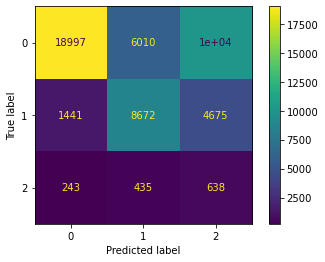

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# make predictions using your model
y_pred = model.predict(X_test)

# convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# create the confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
